In [16]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution

In [17]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)


5


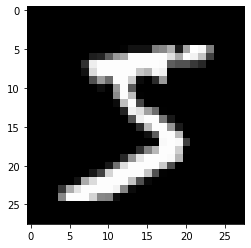

In [18]:
feature = trainset[0][0]
label = trainset[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


Here, I will first implement a BNN such as in the PAI Task 2. Thus it will be a BNN that is trained via Bayes by Backprop. We will need to change this to train the BNN via SG-MCMC as we said in the Proposal.

First, we need to define the Prior distributions which we will later use in the BNN.

In [19]:
class Prior(nn.Module, abc.ABC):
    """
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/prior/base.py
    """
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        pass
    
    @abc.abstractmethod
    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Don't use this method, we only implement it because nn.Module requires it
        Vincent Fortuin uses the forward to return the parameter value using self.p
        """
        return self.log_likelihood(x)


In [ ]:
class Isotropic_Gaussian2(Distribution):
    """ CAVEAT: Not sure if this is correct. Probably not even needed. Just use dist.normal"""
    def __init__(self, loc: torch.Tensor, scale: torch.Tensor):
        super(Isotropic_Gaussian, self).__init__()
        assert scale > 0, "Scale must be positive."
        self.loc = loc
        self.scale = scale

    def log_prob(self, values: torch.Tensor) -> torch.Tensor:
        return -0.5 * torch.log(2 * torch.pi * self.scale ** 2) - (values - self.loc) ** 2 / (2 * self.scale ** 2)
    def sample(self, sample_shape=torch.Size()):
        return torch.normal(self.loc, self.scale, sample_shape)

    def entropy(self):
        return 0.5 * torch.log(2 * torch.pi * torch.e) + torch.log(self.scale)

    def kl_divergence(self, other):
        return torch.log(self.scale / other.scale) + (other.scale ** 2 + (self.loc - other.loc) ** 2) / (2 * self.scale ** 2) - 0.5

    def mean(self):
        return self.loc

    def std(self):
        return self.scale

    def mode(self):
        return self.loc



class Isotropic_Gaussian(Distribution):
    """
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/prior/loc_scale.py
    """
    pass


Next, we need to define a basic module for one single Bayesian Layer. This module will then be used as building block for the full BNN. 


In [48]:
class Linear_Layer(nn.Linear):
    """
    Bayesian Linear Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """ 
    def __init__(self, in_features, out_features, bias = True):
        super().__init__(in_features, out_features, bias)
        self.in_features = in_features
        self.out_features = out_features
        self.with_bias = bias

        # create a prior for the weights and biases using the Isotropic Gaussian prior
        self.weight_prior = Isotropic_Gaussian(
            mu = torch.zeros(out_features, in_features),
            sigma = torch.ones(out_features, in_features)
        )

        if bias:
            self.bias_prior = Isotropic_Gaussian(
                mu = torch.zeros(out_features),
                sigma = torch.ones(out_features)
            )
        
        # create a variational posterior for the weights and biases as Instance of Isotropic Gaussian
        self.weight_posterior = Isotropic_Gaussian(
            mu = torch.nn.Parameter(torch.zeros(out_features, in_features)),
            sigma = torch.nn.Parameter(torch.ones(out_features, in_features))
        )

        if bias:
            self.bias_posterior = Isotropic_Gaussian(
                mu = torch.nn.Parameter(torch.zeros(out_features)),
                sigma = torch.nn.Parameter(torch.ones(out_features))
            )
        else:
            self.register_parameter('bias', None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # sample weights and biases from the variational posterior
        weight = self.weight_posterior.sample()
        bias = self.bias_posterior.sample() if self.with_bias else None

        # compute the log-likelihood of the weights and biases
        log_prior = self.weight_prior.log_likelihood(weight) + self.bias_prior.log_likelihood(bias)

        # compute the log posterior of the weights and biases
        log_posterior = self.weight_posterior.log_likelihood(weight) + self.bias_posterior.log_likelihood(bias)

        # compute the output of the layer
        output = F.linear(x, weight, bias)

        return output, log_prior, log_posterior    


class Bayesian_Neural_Network(nn.Module):
    """
    Bayesian Neural Network that will be trained using the BNN implementation
    """ 
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # create the layers of the network
        self.input_layer = Linear_Layer(in_features=self.input_size, out_features=self.hidden_size)
        self.hidden_layer = Linear_Layer(in_features=self.hidden_size, out_features=self.hidden_size)
        self.output_layer = Linear_Layer(in_features=self.hidden_size, out_features=self.output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # compute the output of the input layer
        x, log_prior, log_posterior = self.input_layer(x)
        x = F.relu(x)

        # compute the output of the hidden layer
        x, log_prior, log_posterior = self.hidden_layer(x)
        x = F.relu(x)

        # compute the output of the output layer
        x, log_prior, log_posterior = self.output_layer(x)

        return x, log_prior, log_posterior

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        # compute the output of the network
        x, _, _ = self.forward(x)

        # compute the class probabilities
        x = F.softmax(x, dim=1)

        return x

    def predict_class(self, x: torch.Tensor) -> torch.Tensor:
        # compute the class probabilities
        x = self.predict(x)

        # compute the class predictions
        x = x.argmax(dim=1)

        return x


# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_size=28*28, hidden_size=100, output_size=10)

# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs = 15
progress_bar = tqdm.trange(epochs)

for epoch in progress_bar:
    for x, y in train_loader:
        # reshape the input
        x = x.view(-1, 28*28)

        # compute the output of the network
        y_hat, log_prior, log_posterior = model(x)

        # compute the loss
        loss = loss_fn(y_hat, y) - log_prior + log_posterior

        # compute the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # reset the gradients
        optimizer.zero_grad()

    # compute the accuracy
    accuracy = (model.predict_class(x) == y).float().mean()

    # update the progress bar
    progress_bar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.2f}, Accuracy: {accuracy:.2f}")




Epoch: 15, Loss: 952.23, Accuracy: 0.12: 100%|██████████| 15/15 [07:02<00:00, 28.20s/it] 


In [49]:
# some changes
print("Hello World")

Hello World


In [ ]:
class Conv_Layer(nn.Conv2d):
    """
    Bayesian Convolutional Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = True):
        super(Conv_Layer, self).__init__()
        pass

In [ ]:
class Bayesian_FCN(nn.Module):
    """
    Bayesian Fully Connected Neural Network
    https://arxiv.org/pdf/2102.06571.pdf
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/dense_nets.py
    """
    def __init__(self, input_size: int, output_size: int, hidden_sizes: list, activation: str = 'relu'):
        super(Bayesian_FCN, self).__init__()
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass

    def sample_elbo(self, input: torch.Tensor, target: torch.Tensor, samples: int = 1, beta: float = 1.0) -> torch.Tensor:
        pass

    def sample_predict(self, input: torch.Tensor, samples: int = 1) -> torch.Tensor:
        pass

In [ ]:
class Bayesian_CNN(nn.Module):
    """
    Bayesian Convolutional Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/conv_nets.py
    https://arxiv.org/pdf/2102.06571.pdf

    """
    def __init__(self, input_size: int, output_size: int, hidden_sizes: list, activation: str = 'relu'):
        super(Bayesian_CNN, self).__init__()
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass

    def sample_elbo(self, input: torch.Tensor, target: torch.Tensor, samples: int = 1, beta: float = 1.0) -> torch.Tensor:
        pass

    def sample_predict(self, input: torch.Tensor, samples: int = 1) -> torch.Tensor:
        pass